In [183]:
import re
import random
import pandas as pd
import hashlib

In [184]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [185]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Kubernetes Learning Path,21.298932,10.649466,2
FSLogix,487.023267,20.292636,24
JavaScript Concepts,560.904739,7.900067,71
Search Engine Optimization,567.681832,94.613639,6
Powershell,591.918528,49.326544,12
Audit Report Tracker (Sharepoint List),779.865529,48.741596,16
Azure Functions + Visual Studio,809.399099,57.814221,14
Email Auth and Security,842.271589,64.790122,13
DNS,944.075659,59.004729,16
OData,970.184332,64.678955,15


# Histogram

39079.36


<Axes: >

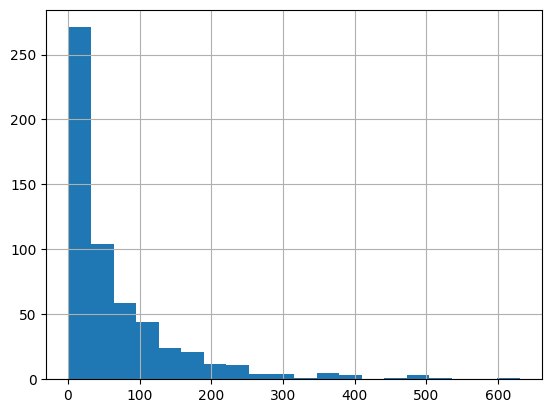

In [186]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [187]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [188]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [189]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [190]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [191]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [192]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [193]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [194]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [195]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Max

In [196]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 569


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Functions + PP365,Function URL\nThe endpoint URL assigned to an ...,2f34def14780bef5e7f4933776a0e00a,-629.779221,106.294762,-629.779221,4570.674747,0.634304,0,0
22,Azure Functions + PP365,Function.json\nA file that defines the binding...,f24a023966a1f7c53fe2f5fbf5581439,-257.151172,106.294762,-629.779221,4570.674747,0.634304,3,0
52,Azure Functions + PP365,Azure Functions Development Environment\nThe s...,16e52c2e8a8a2a00c2767509a2b4a333,-183.178370,106.294762,-629.779221,4570.674747,0.634304,6,0
91,Azure Functions + PP365,Function App Slots\nSeparate environments with...,a7be9d3a8ca41afb667a4678abb64695,-127.393180,106.294762,-629.779221,4570.674747,0.634304,9,0
126,Azure Functions + PP365,Asyncio\nA Python library used to write concur...,83247a2ddf931474ab4bedbfaa006139,-101.722107,106.294762,-629.779221,4570.674747,0.634304,12,0
158,Azure Functions + PP365,Function Scale-Out\nThe ability of Azure Funct...,1beff98f811b622f5017bf5b31ab45d5,-85.087758,106.294762,-629.779221,4570.674747,0.634304,15,0
177,Azure Functions + PP365,Dynamic Content\nData dynamically pulled from ...,b118b5737fda1188f0c0c0b89d76e75e,-71.222650,106.294762,-629.779221,4570.674747,0.634304,18,0
199,Azure Functions + PP365,Logging\nThe practice of recording information...,811ce272b3cf5bff2fdcb5a7ce09c45b,-60.383776,106.294762,-629.779221,4570.674747,0.634304,21,0
243,Azure Functions + PP365,Azure Function App Logs\nLogs generated by Azu...,fc502a0ad47e15d3be8d28df63c69cfb,-47.108047,106.294762,-629.779221,4570.674747,0.634304,24,0
266,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f0738c66ae6f3de6f880ac7c2431633f,-44.277455,106.294762,-629.779221,4570.674747,0.634304,27,0


## Age Mean

In [197]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [198]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [199]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Functions + PP365,Function URL\nThe endpoint URL assigned to an ...,2f34def14780bef5e7f4933776a0e00a,-629.779221,106.294762,-629.779221,4570.674747,0.634304,0,0
22,Azure Functions + PP365,Function.json\nA file that defines the binding...,f24a023966a1f7c53fe2f5fbf5581439,-257.151172,106.294762,-629.779221,4570.674747,0.634304,3,0
52,Azure Functions + PP365,Azure Functions Development Environment\nThe s...,16e52c2e8a8a2a00c2767509a2b4a333,-183.178370,106.294762,-629.779221,4570.674747,0.634304,6,0
91,Azure Functions + PP365,Function App Slots\nSeparate environments with...,a7be9d3a8ca41afb667a4678abb64695,-127.393180,106.294762,-629.779221,4570.674747,0.634304,9,0
126,Azure Functions + PP365,Asyncio\nA Python library used to write concur...,83247a2ddf931474ab4bedbfaa006139,-101.722107,106.294762,-629.779221,4570.674747,0.634304,12,0
158,Azure Functions + PP365,Function Scale-Out\nThe ability of Azure Funct...,1beff98f811b622f5017bf5b31ab45d5,-85.087758,106.294762,-629.779221,4570.674747,0.634304,15,0
177,Azure Functions + PP365,Dynamic Content\nData dynamically pulled from ...,b118b5737fda1188f0c0c0b89d76e75e,-71.222650,106.294762,-629.779221,4570.674747,0.634304,18,0
199,Azure Functions + PP365,Logging\nThe practice of recording information...,811ce272b3cf5bff2fdcb5a7ce09c45b,-60.383776,106.294762,-629.779221,4570.674747,0.634304,21,0
243,Azure Functions + PP365,Azure Function App Logs\nLogs generated by Azu...,fc502a0ad47e15d3be8d28df63c69cfb,-47.108047,106.294762,-629.779221,4570.674747,0.634304,24,0
266,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f0738c66ae6f3de6f880ac7c2431633f,-44.277455,106.294762,-629.779221,4570.674747,0.634304,27,0


In [200]:
existing_cards['age'].mean()

-68.68078135298478